In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [7]:
data = pd.read_csv('spam.csv',encoding="ISO-8859-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
data.rename(columns={"v1": "target", "v2": "sms"},inplace=True)
df=data.copy()
df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

In [10]:
#check duplicates
df['sms'].duplicated().sum()

403

In [11]:
#remove all duplicate rows
df.drop_duplicates(inplace=True)
#reset index
df.reset_index(inplace=True)
#remove old index column
df.drop("index",axis=1,inplace=True)
#check missing values
df.isna().sum()

target    0
sms       0
dtype: int64

In [12]:
#0->ham (or good sms) 1->spam 
le=LabelEncoder()
df['target']=le.fit_transform(df['target'])
df.head()

,target,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
#cleaning text

lem=nltk.WordNetLemmatizer()

corpus=[]

for i in range(df.shape[0]):
    review=re.sub('[^a-zA-Z]',' ',df['sms'][i])
    review=review.lower()
    corpus.append(review)
df['features']=corpus
df.head()

,target,sms,features
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i don t think he goes to usf he lives aro...


In [14]:
x=df['features']
y=df['target']

In [15]:
cvec=CountVectorizer()
cvdf=cvec.fit_transform(x)
cvdf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [16]:
sm=SMOTE()
x_sm,y_sm=sm.fit_resample(cvdf,y)
y_sm.value_counts()

1    4516
0    4516
Name: target, dtype: int64

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x_sm,y_sm,test_size=0.2,random_state=0)

In [18]:
svm=SVC(kernel='linear')
svm.fit(x_train,y_train)
y_pred=svm.predict(x_test)
accuracy_score(y_test,y_pred)

0.9629219701162147

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc3f90a2b90>)

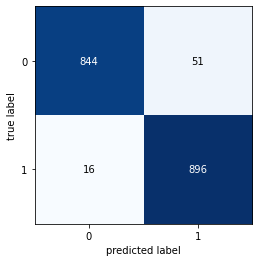

In [19]:
from mlxtend.plotting import plot_confusion_matrix
mat=confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat)

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       895
           1       0.95      0.98      0.96       912

    accuracy                           0.96      1807
   macro avg       0.96      0.96      0.96      1807
weighted avg       0.96      0.96      0.96      1807



In [21]:
sms=["Hey, you have won a car !!!!. Conrgratzz",
     "Dear applicant, Your CV has been recieved. Best regards",
     "YOU ARE CHOSEN TO RECEIVE A å£350 AWARD! Pls call claim to collect your award which you are selected to receive as a valued mobile customer."]

In [22]:
#cleaning text
unseen=[]

for i in range(len(sms)):
    review=re.sub('[^a-zA-Z]',' ',sms[i])
    review=review.lower()
    unseen.append(review)
#0->ham (or good sms) 1->spam 
yp=svm.predict(cvec.transform(unseen))
yp

array([0, 0, 1])